# Does negativity make success?

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from collections import Counter
from helpers import text_from_ids, neg_words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import operator
from wordcloud import WordCloud
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install wordcloud

#### Load the dataframe containing videos from 2019 and their features

This is a big file (860 MB) so we have stored it on Google Drive. Download it from the link below and storie it as `generated/2019/2019_videos_Typo_Emojis_NegWords_Sentiment_title_desc.parquet`. It was generated by the notebook `data_processing.ipynb`.

https://drive.google.com/file/d/1RmVSw2MBq0Ps0dwcTQjqZsDAuivXbUaZ/view?usp=share_link

In [3]:
filepath = 'generated/2019/2019_videos_Typo_Emojis_NegWords_Sentiment_title_desc.parquet'
videos = pd.read_parquet(filepath, engine='fastparquet')

In [4]:
videos.head()

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,upload_date,view_count,count_words_title,...,count_negative_emojis_title,count_upper_words_title,count_excl_marks_title,count_upper_words_description,count_excl_marks_description,count_negative_emojis_description,sia_negative_description,sia_neutral_description,sia_positive_description,sia_compound_description
0,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:57.427254,35,JOeSxtcNdHQ,8620,1673,2019-10-01,48737,6,...,0,0,0,2,0,0,0.000,0.929,0.071,0.0772
1,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:58.108323,15,EPMLTw2zINw,355,1297,2019-10-01,19999,2,...,0,0,0,0,0,0,0.000,0.000,0.000,0.0000
2,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:58.773085,78,Y1_pK68iSYQ,603,3305,2019-09-28,58518,10,...,0,0,0,2,0,0,0.047,0.870,0.084,0.3877
3,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:59.465346,70,jF8TSo3ZfTc,1426,1889,2019-09-21,71998,16,...,0,1,0,10,0,0,0.000,0.943,0.057,0.7213
4,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:40:00.188768,73,Gp00dNaVouo,990,2699,2019-09-14,101924,10,...,0,0,0,15,1,0,0.033,0.967,0.000,-0.3664


## What is negativity?

### Small intro (examples with sia from vader)

## [[Maybe put something more here]] [[Matteo]]

## Regression analysis [[Djian]]

### Overall

try description and title (look at R to find what is best) [[Djian: description is better]]

In [5]:
def print_regression(data, formula):
    model = smf.ols(formula=formula, data=data)
    np.random.seed(2)
    results = model.fit()
    print(results.summary())

In [6]:
# Remove videos where 'like_count' is NaN
videos = videos[videos['like_count'].isna() == False]

# Convert some rows to float
videos['like_count'] = videos['like_count'].astype(float)
videos['dislike_count'] = videos['dislike_count'].astype(float)
videos['view_count'] = videos['view_count'].astype(float)

# New columns for the log of the counts (+1 so that the log is always defined)
videos['log_view_count'] = np.log(videos['view_count'] + 1)
videos['log_like_count'] = np.log(videos['like_count'] + 1)
videos['log_dislike_count'] = np.log(videos['dislike_count'] + 1)

In [7]:
success_factors = ['log_view_count', 'log_like_count', 'log_dislike_count']


def regression_formula(success_factor):
    f = f'{success_factor} ~ '
    f += 'sia_negative_description ' 
    f += '+ sia_positive_description '
    f += '+ sia_neutral_description '
    return f


formulas = [regression_formula(s) for s in success_factors]

for f in formulas:
    print(f'Regression analysis for formula \n{f}')
    print_regression(data=videos, formula=f)
    print('')
    print('')

Regression analysis for formula 
log_view_count ~ sia_negative_description + sia_positive_description + sia_neutral_description 
                            OLS Regression Results                            
Dep. Variable:         log_view_count   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                 7.945e+04
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:36:52   Log-Likelihood:            -2.9834e+07
No. Observations:            12432558   AIC:                         5.967e+07
Df Residuals:                12432554   BIC:                         5.967e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025 

### By category

In [8]:
# Find the categories
categories = set(videos['categories'].values)
categories.remove(None)

In [9]:
regression_for_success_factor = dict()

for success_factor in success_factors:
    f = regression_formula(success_factor)
    
    results_params_f = dict()

    for category in categories:
        videos_category = videos[videos['categories'] == category]
        model = smf.ols(formula=f, data=videos_category)
        np.random.seed(2)
        results = model.fit()
        results_params_f[category] = pd.concat([results.params, results.pvalues], keys=['parameter', 'p-value'])

    df_regression = pd.DataFrame(results_params_f).transpose()
    
    regression_for_success_factor[success_factor] = df_regression

In [10]:
def plot_regression(df_regression):
    
    df_reg = df_regression.copy()
    
    # Drop p-values and `Intercept`, remove index
    df_reg = df_reg['parameter']
    df_reg = df_reg.drop('Intercept', axis=1)
    df_reg = df_reg.reset_index()

    # Plot
    fig, ax = plt.subplots(figsize=(9, 6))
    plt.scatter(x=df_reg['index'], y=df_reg['sia_negative_description'], marker='$:($', color='crimson', s=50)
    plt.scatter(x=df_reg['index'], y=df_reg['sia_neutral_description'],  marker='$:|$', color='gray', s=50)
    plt.scatter(x=df_reg['index'], y=df_reg['sia_positive_description'],  marker='$:)$', color='dodgerblue', s=50)
    plt.xticks(rotation=90)
    plt.ylabel('log_count')
    plt.show()

Linear regression for log_view_count


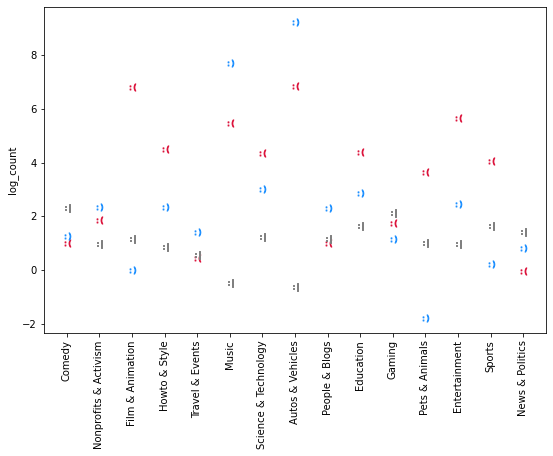


Linear regression for log_like_count


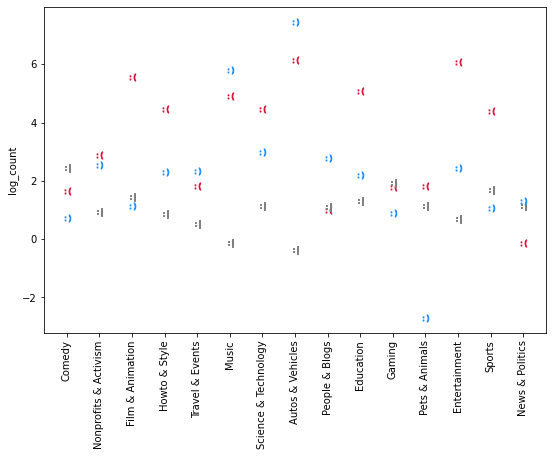


Linear regression for log_dislike_count


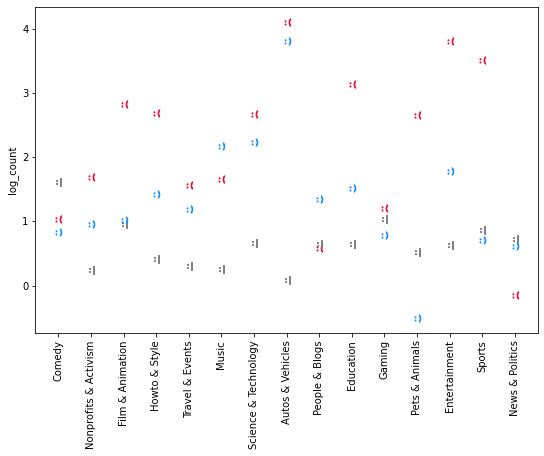

In [11]:
# Plot the regression parameters for various success factors

for success_f in success_factors:
    print(f'Linear regression for {success_f}')
    plot_regression(regression_for_success_factor[success_f])
    print('')

In [12]:
# Alternative: seaborn plot
'''
# Colors for the plot
palette_sentiment = {
    'sia_negative_description': 'crimson',
    'sia_neutral_description': 'gray',
    'sia_positive_description': 'dodgerblue',
    'Intercept': 'black'

}

# Drop p-values and `Intercept`, remove index
df_regression = df_regression['parameter']
df_regression = df_regression.drop('Intercept', axis=1)
df_regression = df_regression.reset_index()

# Convert the dataframe to long form, for seaborn plot
df_regression_melt = df_regression.melt('index', var_name='sentiment_type', value_name='sentiment_value')

# Plot
sns.scatterplot(
    data=df_regression_melt, 
    x='index', 
    y='sentiment_value', 
    hue='sentiment_type',
    s=40,
    marker='D',
    palette=palette_sentiment,
    #aspect=2,
    #jitter=False,  # for vertically aligned datapoints in each category
    alpha=0.8
)
plt.xticks(rotation=90)
plt.show()
'''
' '

' '

## Evolution of channels with negativity [[Victor]]

## What does successful negativity look like?

### Most used words: the vocabulary of videos that are negative and successful (for different categories) [[Maj]]

Make 'histogram' of words in title/desc for videos that are very negative and have lots of success (maybe do it for each category). Example:

https://ldrame21.github.io/metoo-media-impact/#data-story-title

#### What is a negative and successful video?

A negative video is the one with sia_negative_description>= 0.4. 

A successful video is the one with number of views is above the average number of views

In [13]:
df_videos = videos.copy()
df_videos.shape

(12432558, 30)

In [14]:
mean_count = df_videos['view_count'].mean()
print(mean_count)

77631.70776866675


In [15]:
#Select negative and successful videos
df_filtered = df_videos[(df_videos['sia_negative_description'] >= 0.4) & (df_videos['view_count'] >= 80000)]
df_filtered.shape

(1531, 30)

In [16]:
df_filtered.head()

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,upload_date,view_count,count_words_title,...,count_upper_words_description,count_excl_marks_description,count_negative_emojis_description,sia_negative_description,sia_neutral_description,sia_positive_description,sia_compound_description,log_view_count,log_like_count,log_dislike_count
21400,Gaming,UCzORJV8l3FWY4cFO8ot-F2w,2019-11-12 02:55:41.537245,42.0,y5TETxO7ZqM,692,8396.0,2019-04-07,142133.0,1,...,0,0,0,0.688,0.312,0.000,-0.2960,11.864526,9.035630,3.761200
23206,Film & Animation,UCzNWVDZQ55bjq8uILZ7_wyQ,2019-11-18 02:09:41.618076,44.0,yV0ZDLp_oI8,109,412.0,2019-02-21,88990.0,6,...,2,0,0,0.402,0.598,0.000,-0.6166,11.396291,6.023448,3.806662
46983,News & Politics,UCzF4Ryn8TKn64md77gS5Q5Q,2019-11-04 21:06:57.676370,74.0,ouck1WBLLeg,204,1386.0,2019-09-16,88832.0,11,...,0,0,0,0.456,0.544,0.000,-0.7717,11.394513,7.234898,4.317488
64130,People & Blogs,UCzDpGSOP42KGRM1R0Y2-Qfw,2019-11-19 21:43:47.707232,81.0,PIwBmmxD-mM,198,3519.0,2019-04-06,152167.0,9,...,0,0,0,0.412,0.588,0.000,-0.5423,11.932740,8.166216,4.406719
88129,Education,UCz8K1occVvDTYDfFo7N5EZw,2019-11-20 08:19:42.740350,37.0,rRHUR0YjBto,653,848.0,2019-04-30,94392.0,8,...,0,0,0,0.411,0.446,0.143,-0.4588,11.455222,6.744059,3.637586


In [17]:
data_path = 'generated/2019/2019_videos.csv'
video_ids = set(df_filtered['display_id'])
df_title_des= text_from_ids(video_ids, data_path) #contains display_id, title, description and tags

12723124it [03:21, 63142.53it/s]


In [18]:
df_title_des.head()

,display_id,title,description,tags
0,y5TETxO7ZqM,WasabiKun,No description.,"wasabikun,vinesauce"
1,yV0ZDLp_oI8,"ANGRY BIRDS 2 Trailer (Animation, 2019)","ANGRY BIRDS 2 Trailer (Animation, 2019)\n© 201...","cinema,ANGRY BIRDS 2,the angry birds movie 2,a..."
2,ouck1WBLLeg,Family identifies 2 teens accused in attempted...,Family identifies 2 teens accused in attempted...,"crime,local,news,uplate"
3,PIwBmmxD-mM,Wolf in sheep's clothing part2 //play with fir...,Ik the thumbnail looks bad ;;-;,
4,rRHUR0YjBto,Tiffany Moss Penalty Phase Verdict & Sentencin...,Tiffany Moss Penalty Phase Verdict & Sentencin...,"Tiffany Moss Trial,Verdict,Sentencing,Tiffany ..."


In [19]:
# merge both dataframes
df_combined = pd.merge(df_filtered, df_title_des, on="display_id")
df_combined.head()

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,upload_date,view_count,count_words_title,...,sia_negative_description,sia_neutral_description,sia_positive_description,sia_compound_description,log_view_count,log_like_count,log_dislike_count,title,description,tags
0,Gaming,UCzORJV8l3FWY4cFO8ot-F2w,2019-11-12 02:55:41.537245,42.0,y5TETxO7ZqM,692,8396.0,2019-04-07,142133.0,1,...,0.688,0.312,0.000,-0.2960,11.864526,9.035630,3.761200,WasabiKun,No description.,"wasabikun,vinesauce"
1,Film & Animation,UCzNWVDZQ55bjq8uILZ7_wyQ,2019-11-18 02:09:41.618076,44.0,yV0ZDLp_oI8,109,412.0,2019-02-21,88990.0,6,...,0.402,0.598,0.000,-0.6166,11.396291,6.023448,3.806662,"ANGRY BIRDS 2 Trailer (Animation, 2019)","ANGRY BIRDS 2 Trailer (Animation, 2019)\n© 201...","cinema,ANGRY BIRDS 2,the angry birds movie 2,a..."
2,News & Politics,UCzF4Ryn8TKn64md77gS5Q5Q,2019-11-04 21:06:57.676370,74.0,ouck1WBLLeg,204,1386.0,2019-09-16,88832.0,11,...,0.456,0.544,0.000,-0.7717,11.394513,7.234898,4.317488,Family identifies 2 teens accused in attempted...,Family identifies 2 teens accused in attempted...,"crime,local,news,uplate"
3,People & Blogs,UCzDpGSOP42KGRM1R0Y2-Qfw,2019-11-19 21:43:47.707232,81.0,PIwBmmxD-mM,198,3519.0,2019-04-06,152167.0,9,...,0.412,0.588,0.000,-0.5423,11.932740,8.166216,4.406719,Wolf in sheep's clothing part2 //play with fir...,Ik the thumbnail looks bad ;;-;,
4,Education,UCz8K1occVvDTYDfFo7N5EZw,2019-11-20 08:19:42.740350,37.0,rRHUR0YjBto,653,848.0,2019-04-30,94392.0,8,...,0.411,0.446,0.143,-0.4588,11.455222,6.744059,3.637586,Tiffany Moss Penalty Phase Verdict & Sentencin...,Tiffany Moss Penalty Phase Verdict & Sentencin...,"Tiffany Moss Trial,Verdict,Sentencing,Tiffany ..."


In [20]:
# remove stopwords from titles 
def remove_stopwords(df):
    df_cleaned = df.copy()
    df_cleaned['tokens'] = df_cleaned['tags'].apply(lambda title: title.split())
    stop_words = stopwords.words('english')
    df_cleaned['tokens'] = df_cleaned['tokens'].apply(lambda tokens: [token for token in tokens if token.lower() not in stop_words])
    return df_cleaned

df_cleaned = remove_stopwords(df_combined)
df_cleaned.head()

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,upload_date,view_count,count_words_title,...,sia_neutral_description,sia_positive_description,sia_compound_description,log_view_count,log_like_count,log_dislike_count,title,description,tags,tokens
0,Gaming,UCzORJV8l3FWY4cFO8ot-F2w,2019-11-12 02:55:41.537245,42.0,y5TETxO7ZqM,692,8396.0,2019-04-07,142133.0,1,...,0.312,0.000,-0.2960,11.864526,9.035630,3.761200,WasabiKun,No description.,"wasabikun,vinesauce","[wasabikun,vinesauce]"
1,Film & Animation,UCzNWVDZQ55bjq8uILZ7_wyQ,2019-11-18 02:09:41.618076,44.0,yV0ZDLp_oI8,109,412.0,2019-02-21,88990.0,6,...,0.598,0.000,-0.6166,11.396291,6.023448,3.806662,"ANGRY BIRDS 2 Trailer (Animation, 2019)","ANGRY BIRDS 2 Trailer (Animation, 2019)\n© 201...","cinema,ANGRY BIRDS 2,the angry birds movie 2,a...","[cinema,ANGRY, BIRDS, 2,the, angry, birds, mov..."
2,News & Politics,UCzF4Ryn8TKn64md77gS5Q5Q,2019-11-04 21:06:57.676370,74.0,ouck1WBLLeg,204,1386.0,2019-09-16,88832.0,11,...,0.544,0.000,-0.7717,11.394513,7.234898,4.317488,Family identifies 2 teens accused in attempted...,Family identifies 2 teens accused in attempted...,"crime,local,news,uplate","[crime,local,news,uplate]"
3,People & Blogs,UCzDpGSOP42KGRM1R0Y2-Qfw,2019-11-19 21:43:47.707232,81.0,PIwBmmxD-mM,198,3519.0,2019-04-06,152167.0,9,...,0.588,0.000,-0.5423,11.932740,8.166216,4.406719,Wolf in sheep's clothing part2 //play with fir...,Ik the thumbnail looks bad ;;-;,,[]
4,Education,UCz8K1occVvDTYDfFo7N5EZw,2019-11-20 08:19:42.740350,37.0,rRHUR0YjBto,653,848.0,2019-04-30,94392.0,8,...,0.446,0.143,-0.4588,11.455222,6.744059,3.637586,Tiffany Moss Penalty Phase Verdict & Sentencin...,Tiffany Moss Penalty Phase Verdict & Sentencin...,"Tiffany Moss Trial,Verdict,Sentencing,Tiffany ...","[Tiffany, Moss, Trial,Verdict,Sentencing,Tiffa..."


In [21]:
#select the 5 most successful categories based on view_count
grouped = df_cleaned.groupby("categories")
most_successful = {}
for name, group in grouped:
    most_successful[name] = group['view_count'].mean()
sorted_dict = sorted(most_successful.items(), key=operator.itemgetter(1), reverse=True)[:5]
print(sorted_dict)

[('Nonprofits & Activism', 2467668.5), ('Pets & Animals', 1542240.5555555555), ('Science & Technology', 949954.0666666667), ('Entertainment', 800284.3859060403), ('Sports', 763225.6666666666)]


## Most common negative words in the most successful categories

In [22]:
# Find the most common words in the most 5 successful categories 
common_words_with_freq = {}

categorie_groups = df_cleaned.groupby("categories")
for name, group in categorie_groups:
    flattened = [val for sublist in group['tokens'].tolist() for val in sublist]
    common_words_with_freq[name] = Counter(flattened).most_common(100)
#convert the dict to a dataframe   
L = [(k, *t) for k, v in common_words_with_freq.items() for t in v]
df_success = pd.DataFrame(L, columns=['categories','common_words','frequency'])
df_success

,categories,common_words,frequency
0,Autos & Vehicles,vs,13
1,Autos & Vehicles,driver,9
2,Autos & Vehicles,2019,8
3,Autos & Vehicles,Sportage,8
4,Autos & Vehicles,crash,8
...,...,...,...
1317,Sports,"missed,goalkeeper",1
1318,Sports,"missed,goalkeepers",1
1319,Sports,"miss,goalkeeper,goalkeepers,football",1
1320,Sports,"goalkeepers,soccer",1


In [23]:
df_success_all = pd.DataFrame(common_words_with_freq.items(), columns=['categories', 'most_common_words'])
df_success_all

,categories,most_common_words
0,Autos & Vehicles,"[(vs, 13), (driver, 9), (2019, 8), (Sportage, ..."
1,Comedy,"[(family, 7), (old, 3), (fails, 3), (mango, 3)..."
2,Education,"[(war, 42), (amendment, 25), (legacy, 19), (rh..."
3,Entertainment,"[(live, 73), (stories, 37), (moments, 36), (gh..."
4,Film & Animation,"[(Wars, 29), (2, 14), (scary, 12), (dubbed, 9)..."
5,Gaming,"[(5, 395), (war, 229), (may, 218), (boss, 210)..."
6,Howto & Style,"[(husqvarna, 9), (mouse, 7), (nighty, 5), (cut..."
7,Music,"[(-, 25), (trap, 20), (sabotage, 17), (dumb, 1..."
8,News & Politics,"[(News, 33), (tv, 24), (pulwama, 21), (attack,..."
9,Nonprofits & Activism,"[(plane, 2), (landing,emergency, 2), (emergenc..."


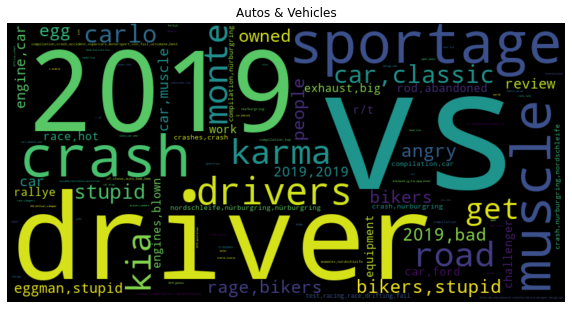

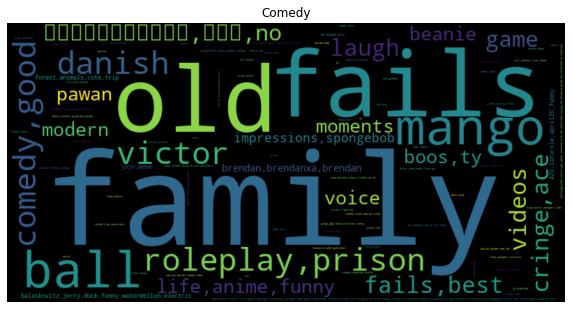

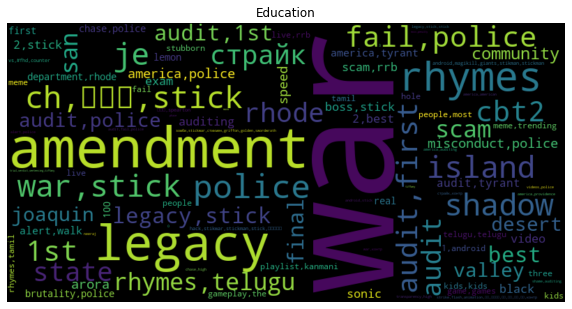

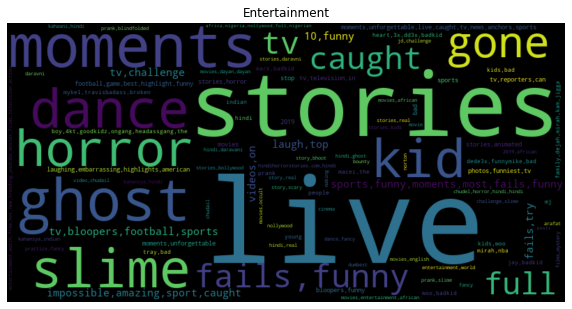

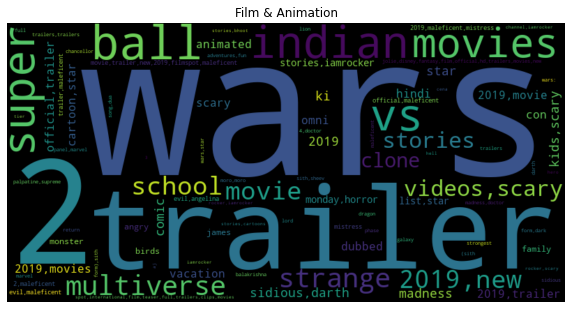

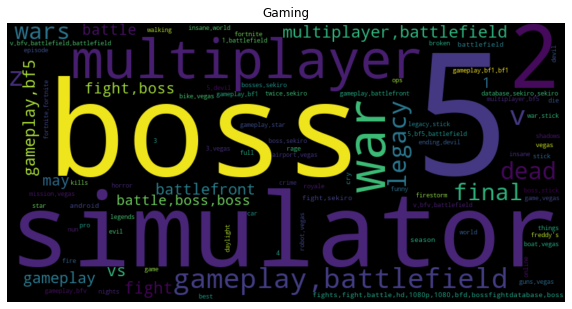

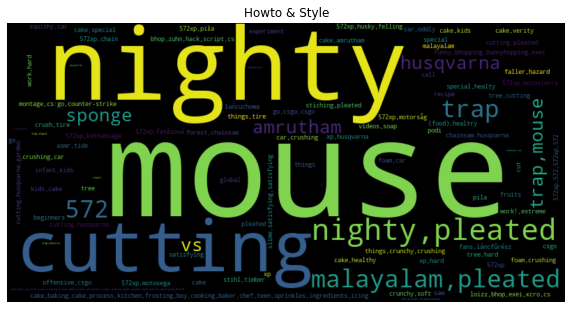

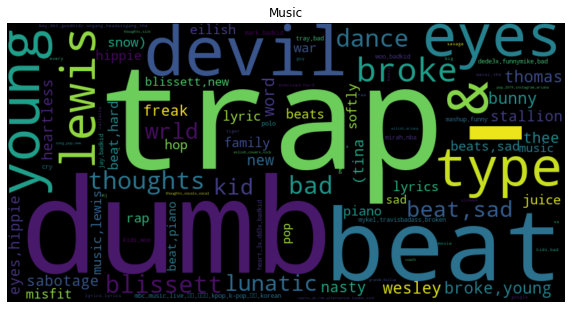

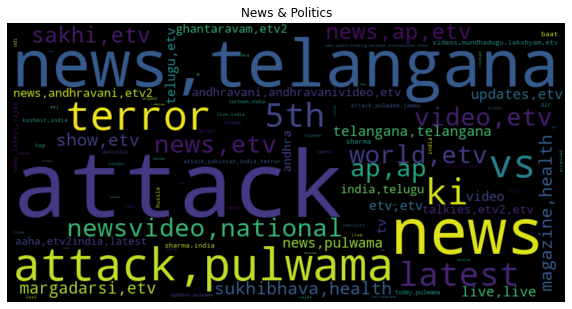

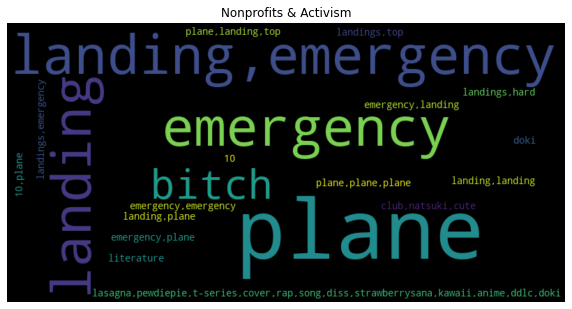

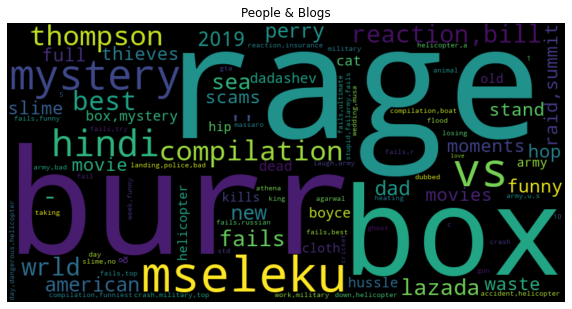

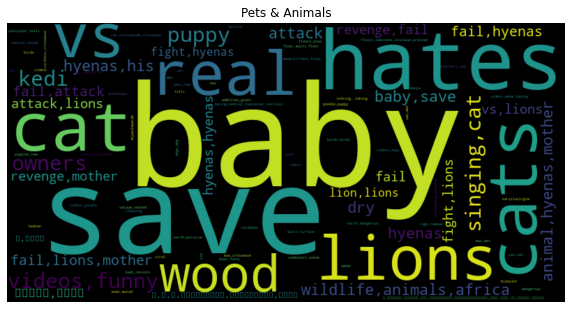

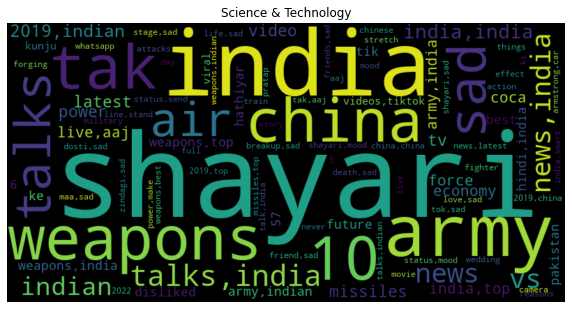

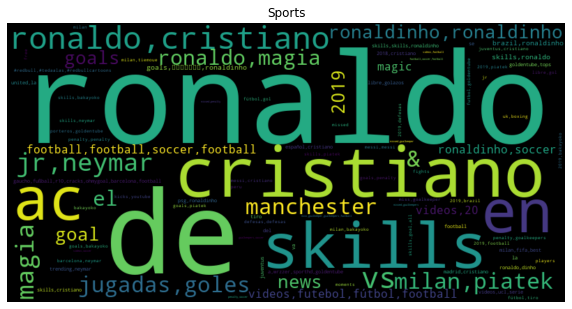

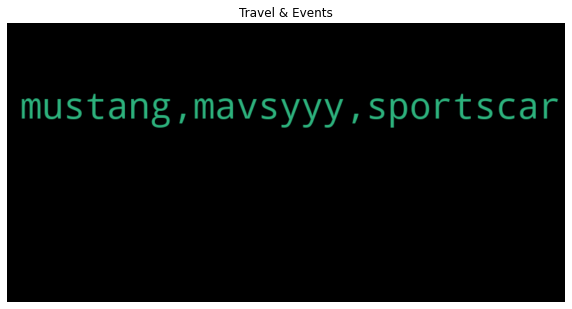

In [24]:
grouped = df_success.groupby("categories")
for name, group in grouped:
    group_words = [item.lower() for item in grouped['common_words'].get_group(name).tolist()]
    #group_neg_words = list(set(group_words) & neg_set)
    if(len(group_words) != 0):
        group_freq = grouped['frequency'].get_group(name).tolist()
        data = dict(zip(group_words, group_freq))
        wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(data)
        plt.figure(figsize=(10, 10))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(name)
        plt.show()       

# What topics appear the most in negative and successful videos? 

In [25]:
# Dont forget the put the reference

In [26]:
import nltk
from nltk.stem import *
import re 
import gensim
import pickle 

In [27]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [28]:
#sucessful and negative videos: df_cleaned
df_cleaned.head()

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,upload_date,view_count,count_words_title,...,sia_neutral_description,sia_positive_description,sia_compound_description,log_view_count,log_like_count,log_dislike_count,title,description,tags,tokens
0,Gaming,UCzORJV8l3FWY4cFO8ot-F2w,2019-11-12 02:55:41.537245,42.0,y5TETxO7ZqM,692,8396.0,2019-04-07,142133.0,1,...,0.312,0.000,-0.2960,11.864526,9.035630,3.761200,WasabiKun,No description.,"wasabikun,vinesauce","[wasabikun,vinesauce]"
1,Film & Animation,UCzNWVDZQ55bjq8uILZ7_wyQ,2019-11-18 02:09:41.618076,44.0,yV0ZDLp_oI8,109,412.0,2019-02-21,88990.0,6,...,0.598,0.000,-0.6166,11.396291,6.023448,3.806662,"ANGRY BIRDS 2 Trailer (Animation, 2019)","ANGRY BIRDS 2 Trailer (Animation, 2019)\n© 201...","cinema,ANGRY BIRDS 2,the angry birds movie 2,a...","[cinema,ANGRY, BIRDS, 2,the, angry, birds, mov..."
2,News & Politics,UCzF4Ryn8TKn64md77gS5Q5Q,2019-11-04 21:06:57.676370,74.0,ouck1WBLLeg,204,1386.0,2019-09-16,88832.0,11,...,0.544,0.000,-0.7717,11.394513,7.234898,4.317488,Family identifies 2 teens accused in attempted...,Family identifies 2 teens accused in attempted...,"crime,local,news,uplate","[crime,local,news,uplate]"
3,People & Blogs,UCzDpGSOP42KGRM1R0Y2-Qfw,2019-11-19 21:43:47.707232,81.0,PIwBmmxD-mM,198,3519.0,2019-04-06,152167.0,9,...,0.588,0.000,-0.5423,11.932740,8.166216,4.406719,Wolf in sheep's clothing part2 //play with fir...,Ik the thumbnail looks bad ;;-;,,[]
4,Education,UCz8K1occVvDTYDfFo7N5EZw,2019-11-20 08:19:42.740350,37.0,rRHUR0YjBto,653,848.0,2019-04-30,94392.0,8,...,0.446,0.143,-0.4588,11.455222,6.744059,3.637586,Tiffany Moss Penalty Phase Verdict & Sentencin...,Tiffany Moss Penalty Phase Verdict & Sentencin...,"Tiffany Moss Trial,Verdict,Sentencing,Tiffany ...","[Tiffany, Moss, Trial,Verdict,Sentencing,Tiffa..."


In [29]:
# remove urls
def remove_url(text):
    return re.sub(r'https?:\S*','',text)
df_cleaned.description = df_cleaned.description.apply(remove_url)

In [30]:
# remove mentions and tags
def remove_mentions_and_tags(text):
    text = re.sub(r'@\S*','',text)
    return re.sub(r'#\S*','',text)
df_cleaned.description = df_cleaned.description.apply(remove_mentions_and_tags)

In [31]:
def preprocessing(df):
    corpus = []
    lem = WordNetLemmatizer() # For Lemmatization
    for news in df['description']:
        words=[w for w in nltk.tokenize.word_tokenize(news) if (w not in stopwords)] # word_tokenize function tokenizes text on each word by default
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus

# Apply this function on our data frame
corpus = preprocessing(df_cleaned)
print(corpus)

[['description'], ['ANGRY', 'BIRDS', 'Trailer', 'Animation', '2019', '2019', 'Sony'], ['Family', 'identifies', 'teen', 'accused', 'attempted', 'robbery', 'killed'], ['thumbnail', 'look', 'bad'], ['Tiffany', 'Moss', 'Penalty', 'Phase', 'Verdict', 'Sentencing'], ['tired', 'seen', 'bad', 'guy'], ['Bad', 'spy', 'dangerous'], ['ⒹiscoveringⓂusic✈', 'They', 'would', "n't", 'share', 'took', 'all.', '✞REBEL✞', 'Eɳʝσყ', 'Sнαre', 'Sυвѕcяιвє', 'Lyrics', 'made', 'devil', 'run', 'gave', 'poison', 'fun', 'one', 'friend', 'none', 'made', 'devil', 'run', 'broke', 'many', 'bone', 'But', 'none', 'ever', 'They', 'army', 'alone', 'broken', 'many', 'bone', 'bad', 'bad', 'bad', 'hard', 'believe', 'see', 'bad', 'bad', 'bad', 'bad', 'take', 'look', 'see', 'bad', 'hard', 'believe', "n't", 'care', 'say', 'bad', 'bad', 'bad', 'watched', 'empire', 'fall', 'stormed', 'gate', 'scared', 'wall', 'They', 'would', "n't", 'share', 'took', 'watched', 'empire', 'fall', 'bad', 'bad', 'bad', 'hard', 'believe', 'see', 'bad', 

In [32]:
# Transform to gensim dictionary
dic = gensim.corpora.Dictionary(corpus) 
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
pickle.dump(bow_corpus, open('corpus.pkl', 'wb'))
dic.save('dictionary.gensim')

In [33]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 15,
                                    id2word = dic,
                                      passes = 10,
                                      workers = 2)
lda_model.save('model15.gensim')

In [34]:
# We print words occuring in each of the topics as we iterate through them
for idx, topic in lda_model.print_topics(num_words=50):    
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.076*"Wars" + 0.073*"Star" + 0.024*"Gameplay" + 0.023*"Multiplayer" + 0.023*"Commentary" + 0.020*"Battlefield" + 0.017*"The" + 0.012*"Conquest" + 0.008*"Jedi" + 0.007*"Episode" + 0.005*"Borderlands" + 0.005*"Empire" + 0.005*"Story" + 0.005*"Clone" + 0.005*"Battlefront" + 0.004*"Weapons" + 0.004*"Force" + 0.004*"Solo" + 0.004*"sorry" + 0.003*"2005" + 0.003*"Breakthrough" + 0.003*"Assault" + 0.003*"2002" + 0.003*"Rogue" + 0.003*"Galactic" + 0.003*"Subscribe" + 0.003*"Kids" + 0.003*"LEGO" + 0.003*"1999" + 0.003*"2000" + 0.003*"COPYRIGHT" + 0.003*"INTENDED" + 0.002*"Doom" + 0.002*"Gun" + 0.002*"1993" + 0.002*"Scary" + 0.002*"1997" + 0.002*"Republic" + 0.002*"INFRINGEMENT" + 0.002*"Sith" + 0.002*"All" + 0.002*"creative" + 0.002*"destruction" + 0.002*"Discord" + 0.002*"Ending" + 0.002*"Firestorm" + 0.002*"War" + 0.002*"Angry" + 0.002*"Battle" + 0.002*"███░░███░░███"
Topic: 1 
Words: 0.019*"death" + 0.017*"suck" + 0.014*"Killed" + 0.014*"2019" + 0.013*"EVIL" + 0.011*"driver"

## Visualizing results

In [35]:
import pyLDAvis
import pyLDAvis.gensim_models

In [36]:
# Loading the dictionary and corpus files we saved earlier
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))

# Loading the num_of_topics = 2 model we saved earlier
lda = gensim.models.ldamodel.LdaModel.load('model15.gensim')
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, bow_corpus, dic, sort_topics=False)
pyLDAvis.display(vis)